In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random

In [68]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score

In [69]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

#sns.set_style('white')
plt.style.use('dark_background')

In [70]:
def compute_usage(df):
    onsets = np.where(np.diff(df['syllables']) != 0)[0]
    usage = df.loc[df.index[onsets], 'syllables'].value_counts(normalize=True)
    return usage

In [71]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllables']).mean()
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

In [72]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

In [73]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_females.parquet')
df = pd.read_parquet(path)

In [74]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [75]:
# calculate usage
fusages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
fusage_mtx = pd.pivot_table(fusages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
fusage_mtx.columns = fusage_mtx.columns.droplevel(0)

#filter most used syllables just females
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [76]:
fdf_all = fusage_mtx.copy()

In [77]:
#get random 16 mice per age
n=16
fdf_all = fdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [78]:
## upload data frame males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_males.parquet')
df = pd.read_parquet(path)

In [79]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [80]:
# calculate usage
musages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
musage_mtx = pd.pivot_table(musages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
musage_mtx.columns = musage_mtx.columns.droplevel(0)

#filter most used syllables just males
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [81]:
mdf_all = musage_mtx.copy()

In [82]:
#get random 16 mice per age
n=16
mdf_all = mdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [83]:
# filter by use of both sexes
combined_df = pd.concat([musages,fusages]).fillna(0)
include_syll = syll_index_above_threshold(combined_df)
mdf = mdf_all[include_syll]
fdf = fdf_all[include_syll]

## decoder

In [84]:
#for males
ymale = mdf.index.get_level_values(0).to_numpy()
Xmale= mdf.to_numpy()
Xmale = np.log(Xmale + 1e-6) # convert to linear

#for females
yfemale = fdf.index.get_level_values(0).to_numpy()
Xfemale= fdf.to_numpy()
Xfemale = np.log(Xfemale + 1e-6) # convert to linear

In [85]:
# choose a model
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 250)
#clf = LinearRegression()
#clf = LinearSVC()

# choose cross validation scheme
#cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.10, random_state=0)
cv=5

#number of iterations for shuffle
it=100

In [86]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh=[]
ysh_predict=[]
ysh_score=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh_score.append(np.mean(y_score_temp))
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


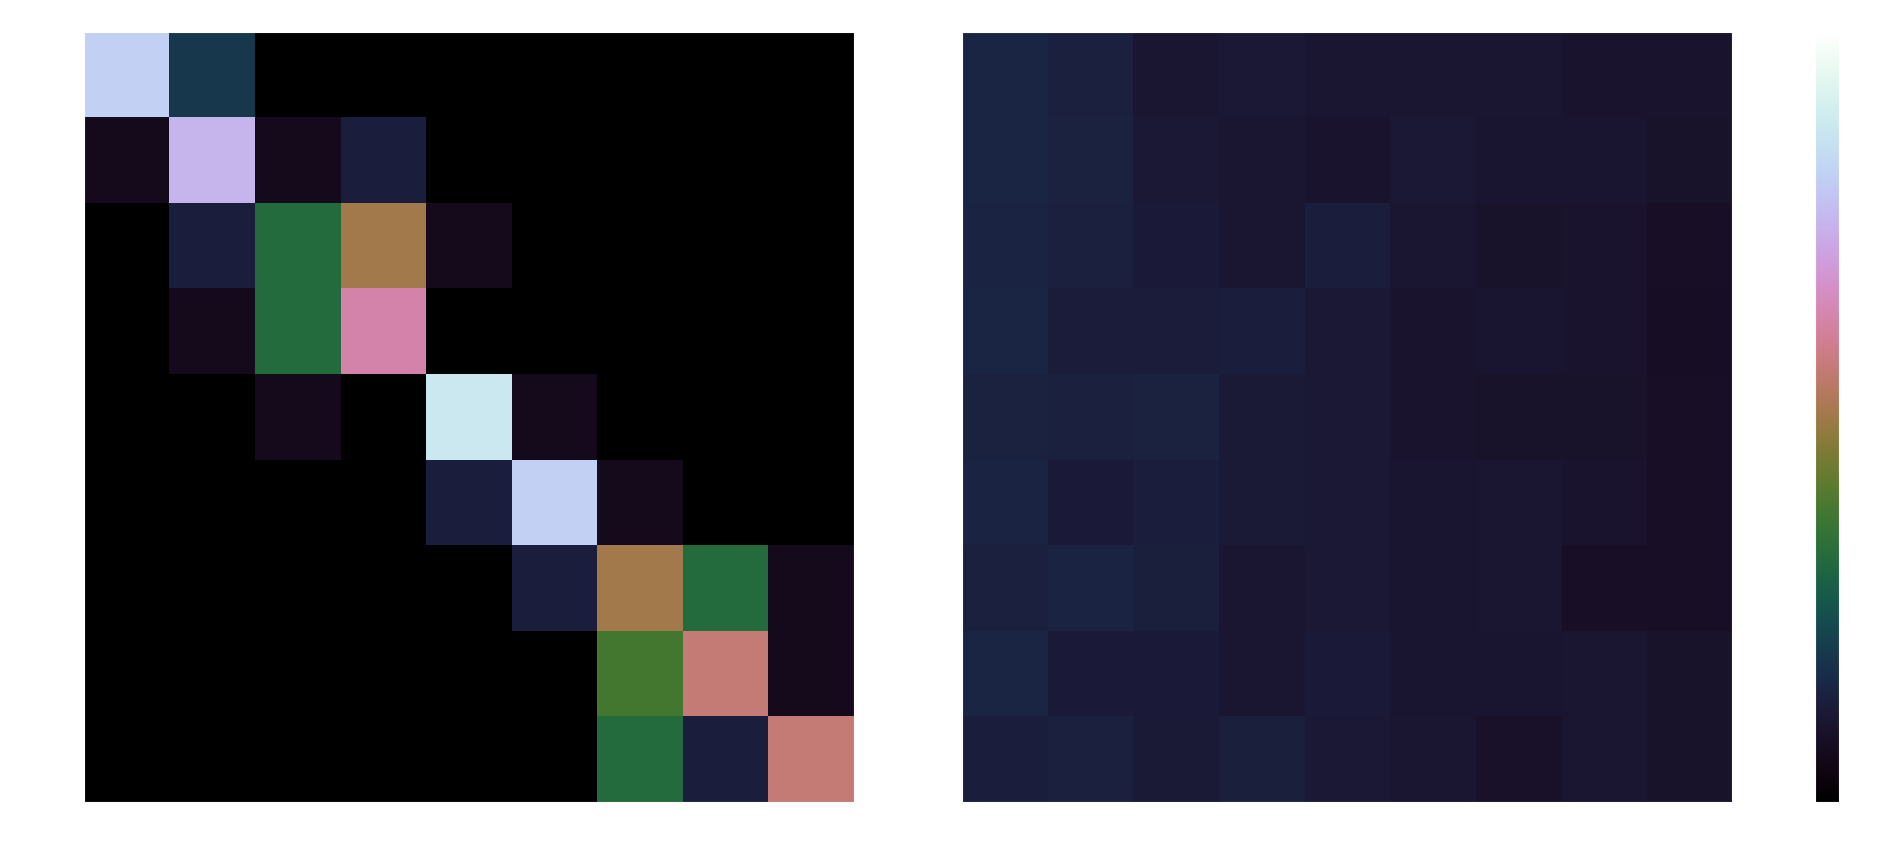

In [87]:
# plot confusion matrix
decoder ='ontogeny_age_decoder_males'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

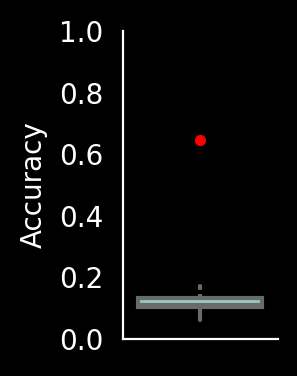

In [88]:
# plot accuracy
shuff_v=pd.DataFrame()
true_acc=pd.DataFrame()
shuff_v['shacc'] = ysh_score
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v['shacc'], showfliers=False, showcaps=False)
ax.plot(0, acc, 'r.')
plt.xticks(ticks=[])
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shacc'].quantile(.95), xmin=0, xmax=1, ls='--', c='k') #plot threshold for significance 
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [89]:
#for females
y_pred = cross_val_predict(clf, Xfemale, yfemale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xfemale, yfemale, cv=cv)))
ysh=[]
ysh_predict=[]
ysh_score=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(yfemale)
    y_pred_temp = cross_val_predict(clf, Xfemale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xfemale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.02it/s]


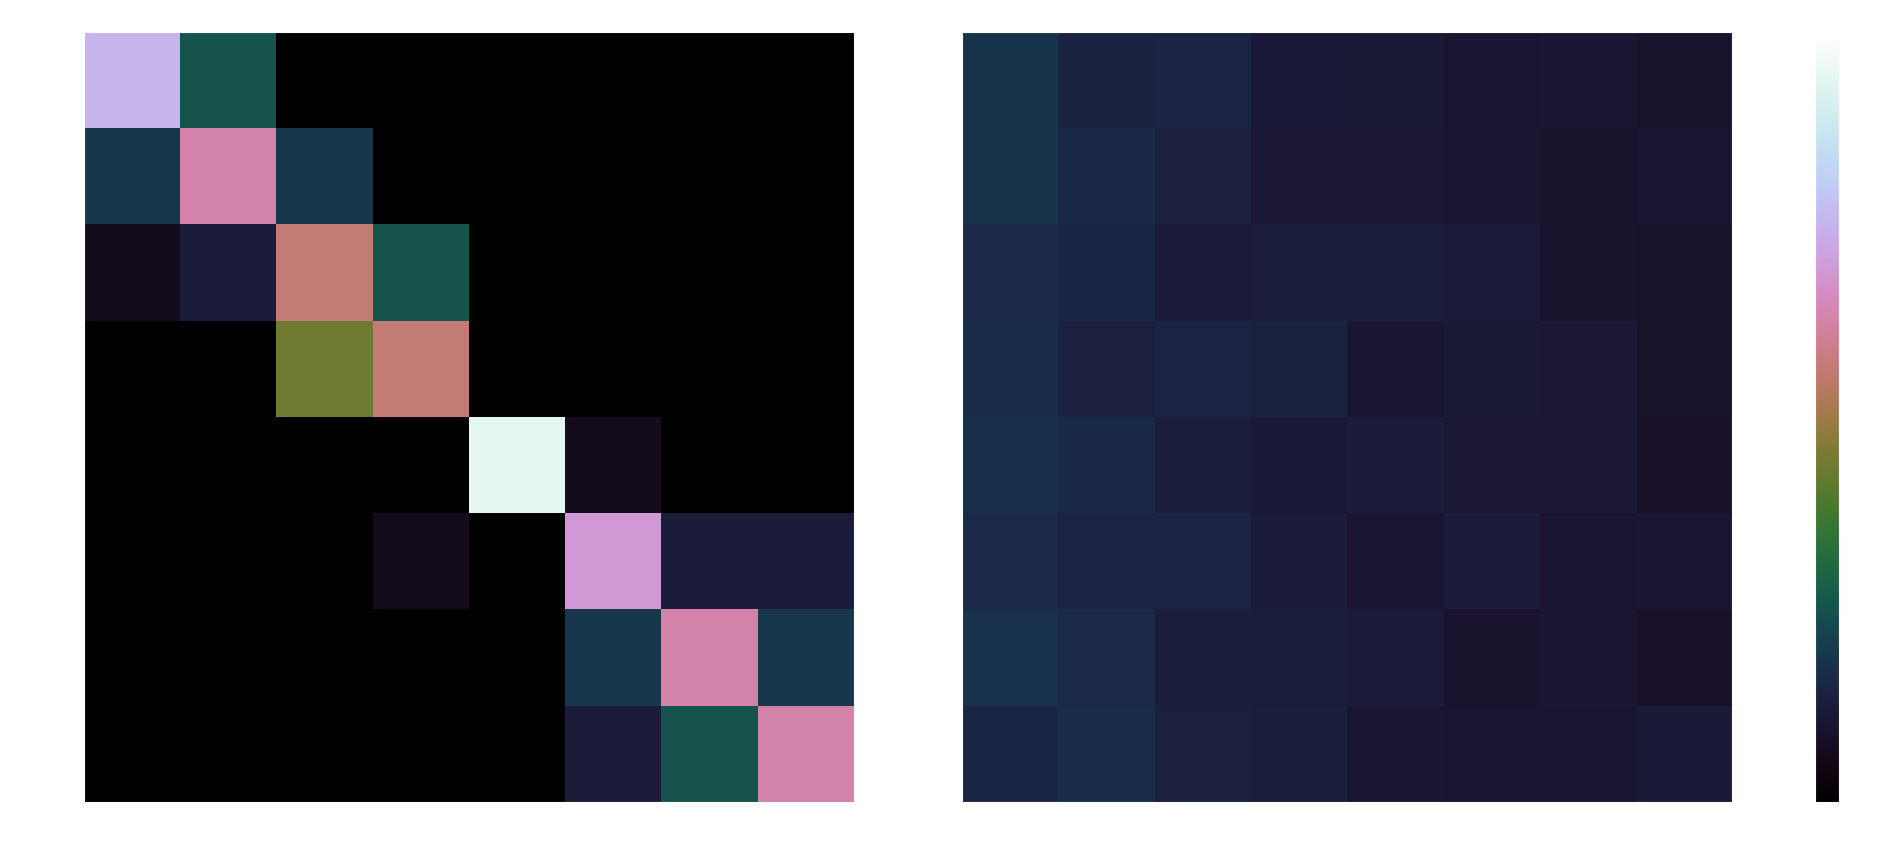

In [90]:
# plot confusion matrix
decoder ='ontogeny_age_decoder_females'
plot_cm(yfemale,y_pred,ysh,ysh_predict,decoder+'_confusion')

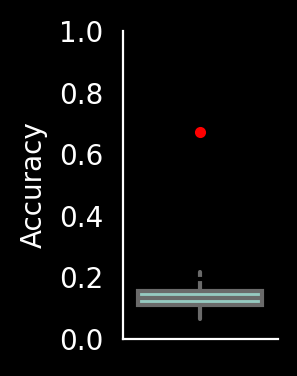

In [91]:
# plot accuracy
shuff_v=pd.DataFrame()
true_acc=pd.DataFrame()
shuff_v['shacc'] = ysh_score
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v['shacc'], showfliers=False, showcaps=False)
ax.plot(0, acc, 'r.')
plt.xticks(ticks=[])
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shacc'].quantile(.95), xmin=0, xmax=1, ls='--', c='k') #plot threshold for significance 
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [92]:
## sex decoder in the different ages

In [93]:
# choose a model
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 150)
#clf = LinearRegression()

# choose cross validation scheme
#cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cv=5

#number of iterations for shuffle
it=100

In [94]:
#combined = pd.concat([fdf,mdf]).fillna(0)
#combined = pd.concat([fdf,mdf])
combined = pd.concat([fdf_all,mdf_all])
combined.dropna(axis=1,inplace=True) # drop syllables that do not exist in one sex
combined = combined.drop('90wks')
combined = np.log(combined + 1e-6) # convert to linear
#combined = combined[include_syll]

acc=[]
sh_acc=[]
ages=[]
ysh=[]
ysh_predict=[]
ysh_ages=[]
ages=[]
for age,_df in enumerate(combined.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).unique().to_numpy())
    #get data
    y=_df[1].index.get_level_values(2).to_numpy()
    X = _df[1].to_numpy()
    #run model
    #y_pred = cross_val_predict(clf, X, y, cv=cv)
    y_pred = cross_val_score(clf, X, y, cv=cv)
    
    for i in tqdm(range(it)):
        ysh_temp=np.random.permutation(y)
        #y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
        y_pred_temp = cross_val_score(clf, X, ysh_temp, cv=cv)
        #ysh.extend(ysh_temp)
        #ysh_predict.extend(y_pred_temp)
        ysh_predict.append(np.mean(y_pred_temp))
        ysh_ages.extend(_df[1].index.get_level_values(0).unique().to_numpy())
        
    acc.append(np.mean(y_pred))
    #sh_acc.append(ysh_predict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.48it/s]


In [95]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=ysh_predict
df_sh['ages'] = ysh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = ages

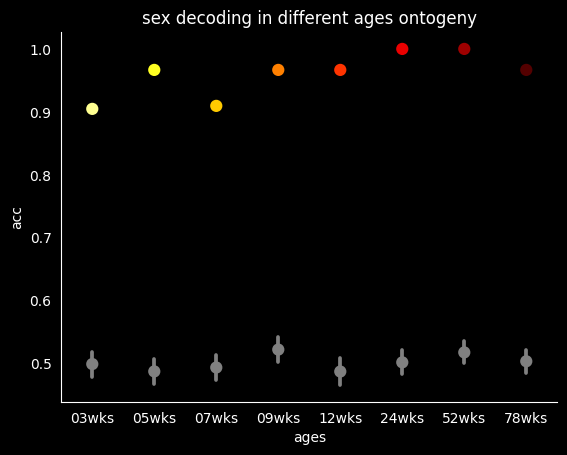

In [98]:
fig, ax = plt.subplots()
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray',join=False)
sns.pointplot(data=df, x="ages", y="acc",
              dodge=0.4, 
              join=False, 
              palette='hot_r',
              ax=ax, 
             )
ax.set_title('sex decoding in different ages ontogeny')
sns.despine()
fig.savefig(data_loc +'sex_decoder_ages_accuracy.pdf', bbox_inches='tight')